In [471]:
%env WORKDIR ~/Documents/weatherpy-work/

import sys
sys.path.append('..')

from wxdata import stormevents

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from wxdata.plotting import (
    sample_colors, plot_cities, LegendBuilder,
    plot_cities_with_geocodor, bottom_right_textbox, inset_colorbar,
    bottom_left_textbox
)
from wxdata.utils import datetime_buckets
from wxdata.extras import st_clusters
from wxdata.stormevents import tors

env: WORKDIR=~/Documents/weatherpy-work/


## Load the tornado data for 4/14/12 and find the clusters

In [2]:
df = stormevents.tornadoes('2012-04-14 12:00', '2012-04-15 12:00', tz='UTC')

In [3]:
clusters = st_clusters(df, eps_km=60, eps_min=60, min_samples=15)

## Prolific Southern Supercell: ~Woodward - Wichita

In [198]:
clust4 = clusters.clusters[4]
clust4.summary()

{'center': (37.17572088353416, -97.88072550200805),
 'max_time': Timestamp('2012-04-15 05:06:00+0000', tz='UTC'),
 'min_time': Timestamp('2012-04-14 22:18:00+0000', tz='UTC'),
 'size': 249,
 'time_spread': Timedelta('0 days 06:48:00')}

In [259]:
from wxdata import radar
radar_order = radar.Level2Archive()

In [473]:
radarfiles = radar_order.select_around('KVNX', '2012-04-15 01:20').download()

In [457]:
def describe_clust(clust):
    description = clust.describe_tors()
    parts = description.split('\n')
    if 'UTC' not in parts[0]:
        parts[0] += ' UTC'
    parts[0] = 'Time range: ' + parts[0]
    return '\n'.join(['Cluster information: '] + parts)

def time_progression_label(a, b):
    return '{} to {} UTC'.format(a.strftime('%H:%M'), b.strftime('%H:%M'))

def plot_bg_tornadoes(cluster_groups, foreground_clust, basemap):
#     shadow = path_effects.SimpleLineShadow(offset=(1, -1), alpha=0.4)
    plot_kw = dict(color='k', linewidth=1, alpha=0.4, patheffect=None)
    
    for clust in cluster_groups.clusters:
        if clust != foreground_clust:
            tors.plot_tornadoes(clust.events, basemap, **plot_kw)
    tors.plot_tornadoes(cluster_groups.noise.events, basemap, **plot_kw)
    
def plot_fg_tor_progression(clust, basemap, time_buckets):
#     shadow = path_effects.SimpleLineShadow(offset=(1, -1), alpha=0.4)
    leg = LegendBuilder(loc=2, fontsize='large')
    tors.plot_time_progression(clust4.events, display.basemap, time_buckets, patheffect=shadow,
                               cmap='viridis', linewidth=1.75, alpha=0.5,
                               legend=leg, legend_handle_func=time_progression_label)
    
def plot_fg_tornadoes(clust, basemap):
    plot_kw = dict(color='k', linewidth=1.5, alpha=0.65, patheffect=None)
    tors.plot_tornadoes(clust.events, basemap, **plot_kw)

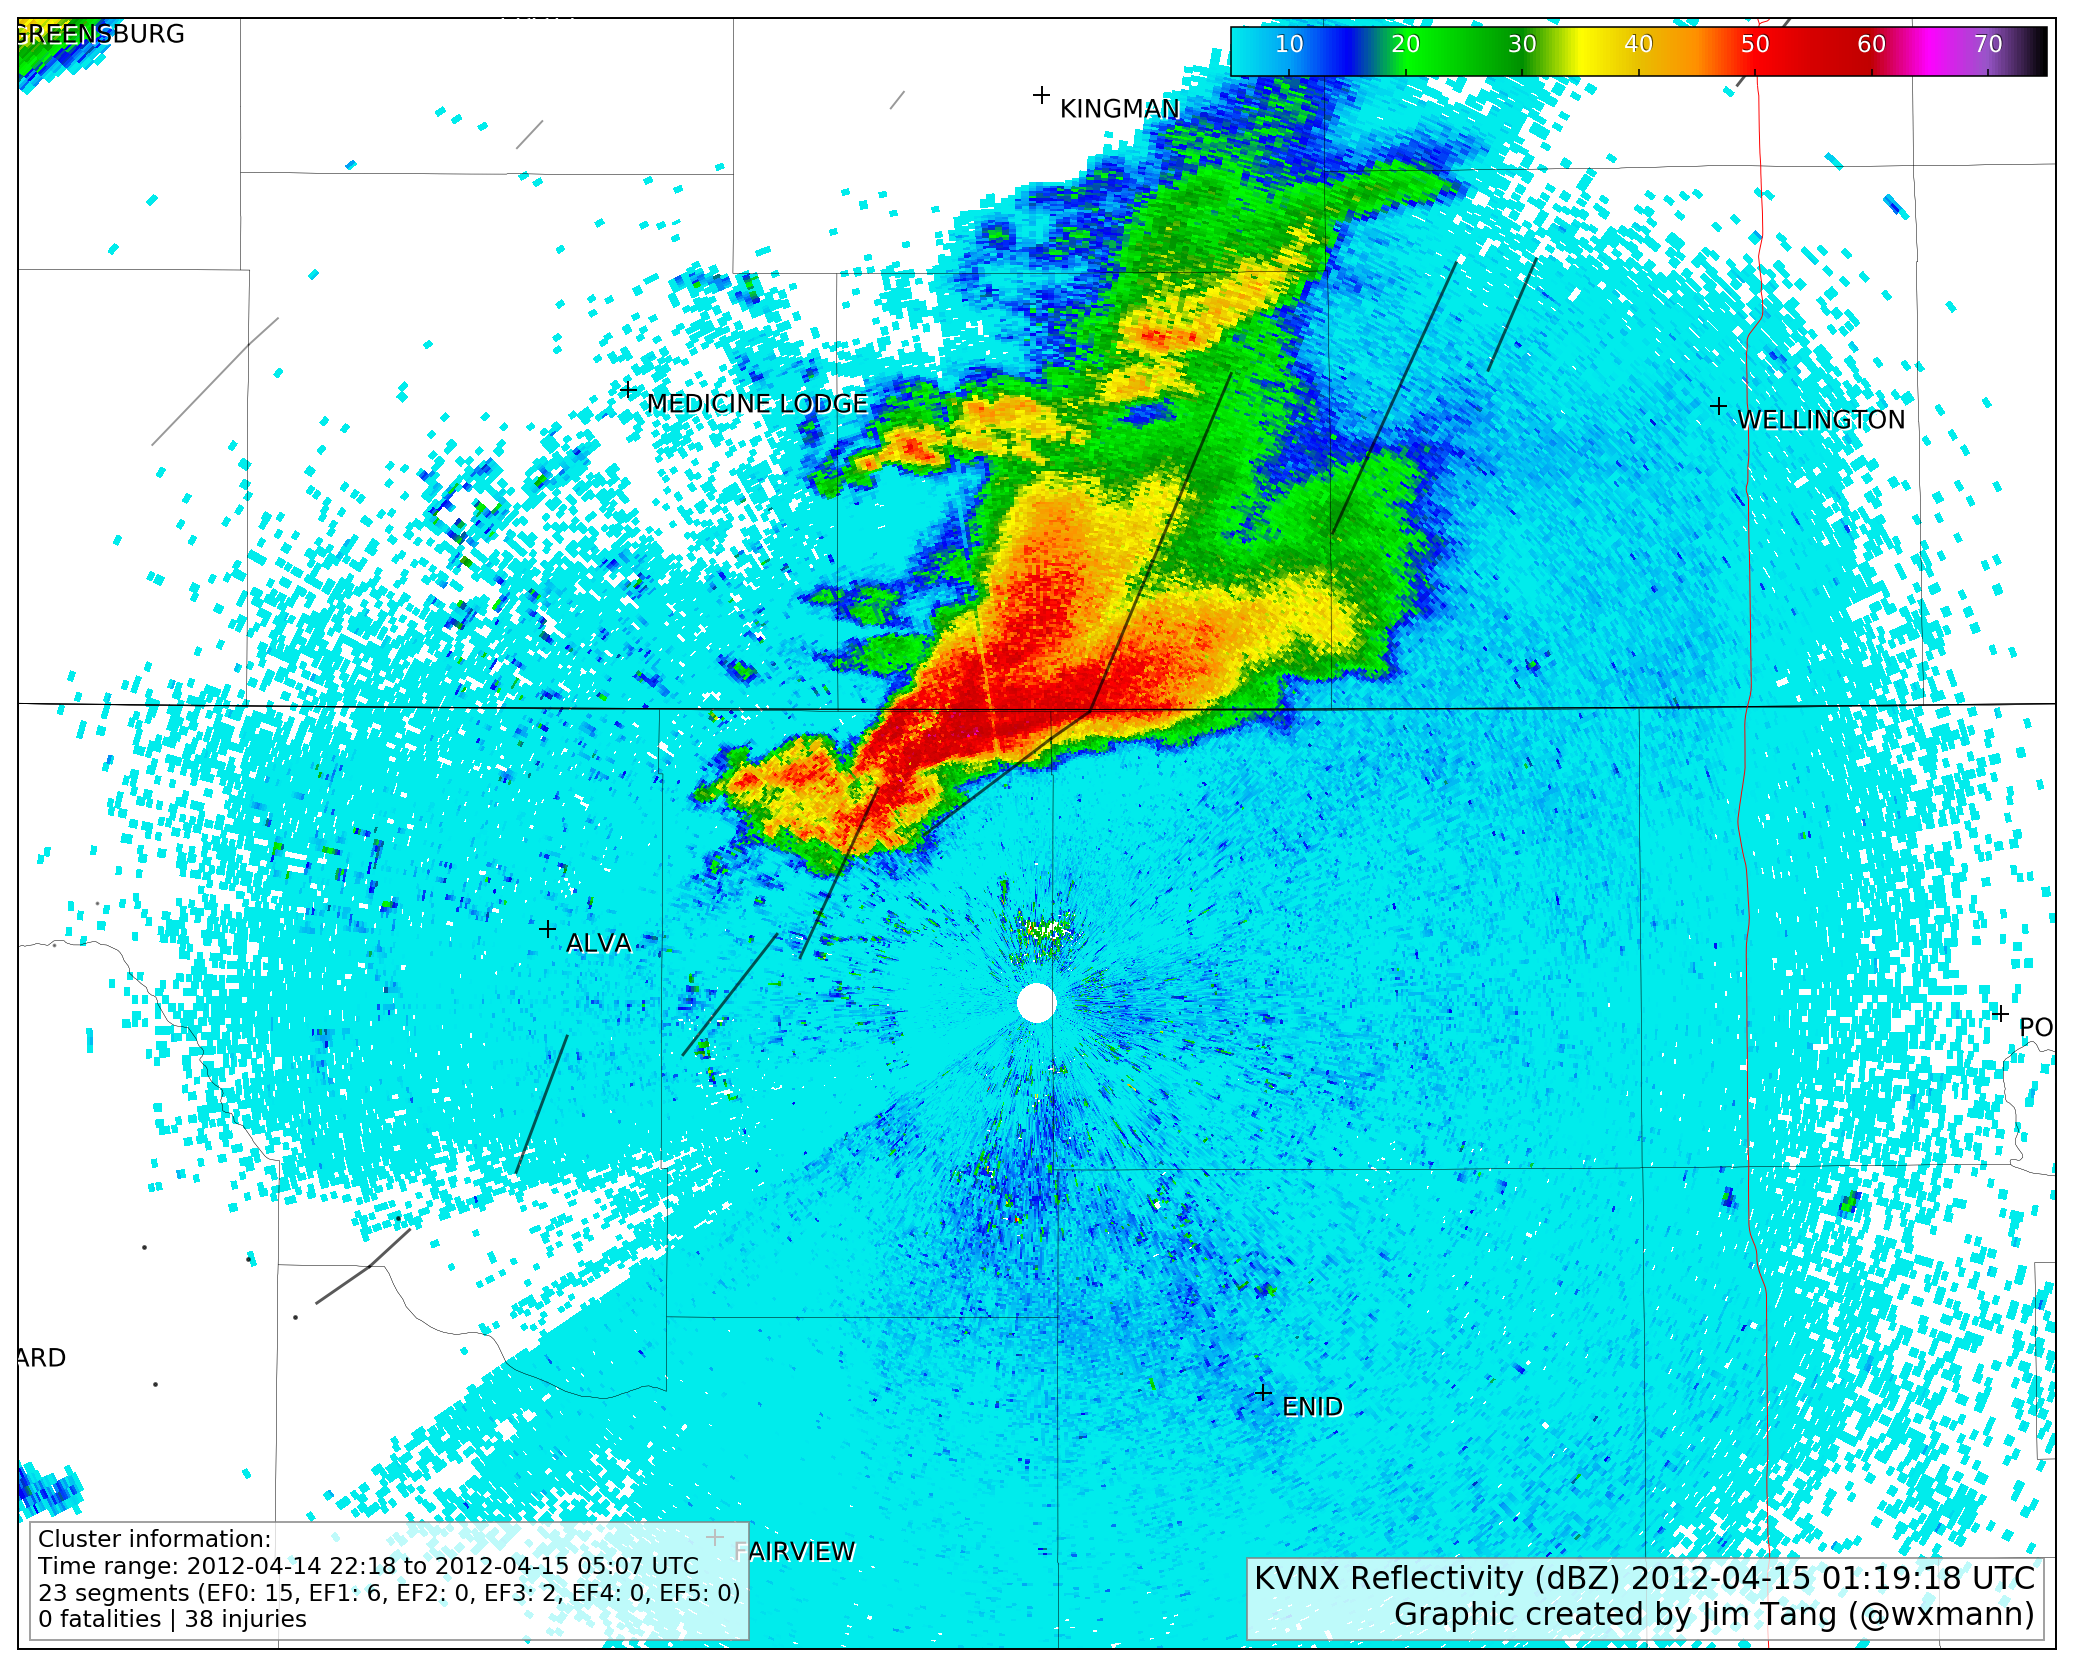

In [474]:
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(16, 12), dpi=140)

bw = ['w', 'k']

# originally zoom (190, 150)
_, display = radar.plot_reflectivity(radarfiles[0], vbounds=(5, 75), zoom_km=(100, 80), 
                                     shift_latlon=(0.15, 0),
                                     map_bg_color=bw[0], map_layer_color=bw[-1])

plot_fg_tornadoes(clust4, display.basemap)
plot_bg_tornadoes(clusters, clust4, display.basemap)

ks_cities = ['Wichita, KS', 'Medicine Lodge, KS', 'Dodge City, KS', 
             'Pratt, KS', 'El Dorado, KS', 'Kingman, KS', 'Greensburg, KS',
            'Wellington, KS']

ok_cities = ['Woodward, OK', 'Ponca City, OK', 'Kingfisher, OK', 'Enid, OK',
            'Alva, OK', 'Buffalo, OK', 'Fairview, OK']

highlighter = path_effects.withSimplePatchShadow(offset=(1, -1), alpha=1.0, 
                                                 shadow_rgbFace=bw[0])
plot_cities_with_geocodor(ks_cities + ok_cities, display.basemap, 
                                  dx=0.02, dy=-0.02, alpha=1.0, labelsize=13, color=bw[-1],
                                  patheffect=[highlighter])

bottom_left_textbox(fig.axes[0], describe_clust(clust4), fontsize='large')

wm = 'KVNX Reflectivity (dBZ) {}\nGraphic created by Jim Tang (@wxmann)'.format(
    radar.timestamp_from_filename(radarfiles[0]).strftime('%Y-%m-%d %H:%M:%S') + ' UTC')
bottom_right_textbox(fig.axes[0], wm) 

cbar, cax = inset_colorbar(display.plots[0], display.basemap.ax, tickcolor='white', loc=1, width='40%')

plt.tight_layout()